# STAT 542 / CS 598: Homework 7
Fall 2019, by Ruoqing Zhu (rqzhu)

Due: Monday, Nov 25 by 11:59 PM Pacific Time

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Question 1 [100 Points] AdaBoost with stump model

## Generate Data

In [5]:
def plot_data(x, y):
    unique = np.unique(y)
    y_plot = y + 0.1*np.random.uniform(-1, 1, len(x))
    for li in range(len(unique)):
        _x = x[y == unique[li]]
        _y = y_plot[y == unique[li]]
        label = 'Positive' if unique[li] == 1 else 'Negative'
        plt.scatter(_x, _y, c = COLOR_LABELS[li], label=label, s=8)
        
#     lines(sort(x), py(x)[order(x)] - 0.5)
#     plt.plot(x, py(y)-0.5, c='blue')
    plt.legend()
    plt.show()

In [6]:
np.random.seed(1)

In [7]:
COLOR_LABELS = ["deepskyblue","darkorange"]

In [8]:
n = 300

In [9]:
x = np.random.uniform(size=n)

In [10]:
py = lambda x: np.sin(4*np.pi*x)/3 + 0.5

In [11]:
y = (np.random.binomial(1, py(x), n)-0.5)*2

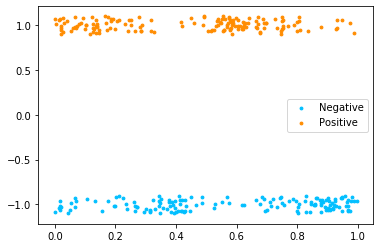

In [12]:
plot_data(x,y)

In [13]:
x_test = np.linspace(0, 1, 1000)

In [14]:
y_test = (np.random.binomial(1, py(x_test), 1000)-0.5)*2

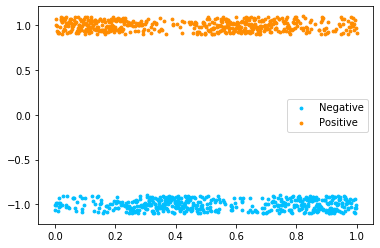

In [15]:
plot_data(x_test,y_test)

## Create model

In [16]:
def exponentialLoss(y, ypred):
    return np.mean(np.exp(-(2. * y - 1.) * ypred))

In [17]:
class Stump():
    def __init__(self):
        self.polarity = 1
        self.threshold = None
        self.loss = None
        self.alpha = None

In [18]:
class MyAdaboost():
    def __init__(self,shrinkage=.5, num_classifiers=10):
        self.num_classifiers = num_classifiers
        self.shrinkage = shrinkage
        self.weights = None
        
    def fit(self,x,y):
        n_samples = len(x)
        weights = np.full(n_samples, (1 / n_samples))
           
        self.classifiers = []
        
        for _ in range(self.num_classifiers):
            classifier = Stump()
            min_error = float('inf')
            
            feature_values = np.expand_dims(x, axis=1)
            unique_values = np.unique(feature_values)
            
            for threshold in unique_values:
                p = 1
                prediction = np.ones(np.shape(y))
                prediction[x < threshold] = -1
                error = sum(weights[y != prediction])

                if error > 0.5:
                    error = 1 - error
                    p = -1

                if error < min_error:
                    classifier.polarity = p
                    classifier.threshold = threshold
                    min_error = error
                    classifier.loss = exponentialLoss(y, prediction)
            
            classifier.alpha = self.shrinkage * np.log((1.0 - min_error) / (min_error + 1e-10))
            predictions = np.ones(np.shape(y))
            negative_idx = (classifier.polarity * x < classifier.polarity * classifier.threshold)
            predictions[negative_idx] = -1
            weights *= np.exp(-classifier.alpha * y * predictions)
            weights /= np.sum(weights)
            
            self.classifiers.append(classifier)
        
        self.weights = weights
    
    def predict(self, x):
        n_samples = len(x)
        y_pred = np.zeros((n_samples, 1))
        
        for classifier in self.classifiers:
            predictions = np.ones(np.shape(y_pred))
            negative_idx = (classifier.polarity * x < classifier.polarity * classifier.threshold)
            predictions[negative_idx] = -1
            
            y_pred += classifier.alpha * predictions
        return np.sign(y_pred).flatten()

In [19]:
number_of_classifiers = 150

In [20]:
model = MyAdaboost(shrinkage=.5, num_classifiers=number_of_classifiers)

In [21]:
model.fit(x, y)

In [22]:
y_pred = model.predict(x_test)

In [23]:
f"Model accuracy {accuracy_score(y_test, y_pred) * 100}%"

'Model accuracy 67.30000000000001%'

## Plot the exponential loss 

In [24]:
loss_values = [clf.loss for clf in model.classifiers]

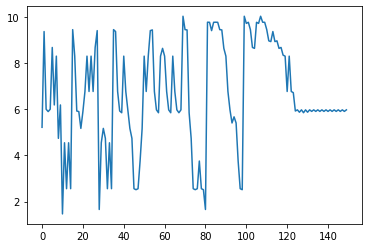

In [25]:
plt.plot(loss_values)
plt.show()

It appears that the best number of classifiers is about 120. After that, the model loss seems to stay the same. 

## Try a few different shrinkage factors and comment on your findings

In [26]:
shrinkage_values = np.arange(.1,1,.1)

In [27]:
scores = []

In [28]:
for val in shrinkage_values:
    s_model = MyAdaboost(shrinkage=val, num_classifiers=number_of_classifiers)
    s_model.fit(x, y)
    y_pred = s_model.predict(x_test)
    score = accuracy_score(y_test, y_pred) * 100
    scores.append(score)

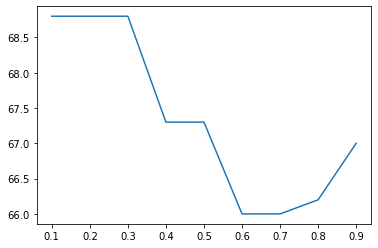

In [29]:
plt.plot(shrinkage_values, scores)
plt.show()

Based on this chart, the best shrinkage value is between .1 and .3. After that, the model accuracy score drops.  

## Plot the final model

In [54]:
best_num_classifiers=120

In [55]:
best_shrinkage=.1

In [56]:
final_model = MyAdaboost(shrinkage=best_shrinkage, num_classifiers=best_num_classifiers)

In [57]:
final_model.fit(x, y)

In [58]:
y_pred = final_model.predict(x_test)

In [59]:
f"Final Model accuracy {accuracy_score(y_test, y_pred) * 100}%"

'Final Model accuracy 68.8%'